### Volumetric visualization of 3-D spheroids (Darling Lab)

Author: Dhananjay Bhaskar

Last Modified: Aug 5, 2018

Resolution (XY): 2.4136 $\text{pixels}/\mu m$

Slice Separation ($\Delta Z$): 2 $\mu m$

- **Red**: Polymer beads
- **Green**: Membrane Stain
- **Blue**: DAPI

##### TODO:

1. Create 3-D rendered image.
2. Count number of blue objects.
3. Distance between red objects (polymer beads): edge-to-edge or centroid-to-centroid. 
4. Quantify size and number of beads

In [1]:
import javabridge
import bioformats

import skimage
import numpy as np
import mahotas as mh
import ipyvolume as ipv
import matplotlib.pyplot as plt

from numba import jit
from scipy import ndimage
from skimage import segmentation

% matplotlib inline

javabridge.start_vm(class_path=bioformats.JARS, max_heap_size='6G')

#### Read multipage TIFF image and extract metadata

In [2]:
filename = 'image_0005_Spheroid_Composite.tif'
img_reader = bioformats.ImageReader(path=filename)

In [3]:
img_rdr = img_reader.rdr
channel_separator = bioformats.ChannelSeparator(rdr=img_rdr)

dim_order = channel_separator.getDimensionOrder()
series_count = channel_separator.getSeriesCount()
img_count = channel_separator.getImageCount()
nchannels = channel_separator.getSizeC()
nrows = channel_separator.getSizeY()
ncols = channel_separator.getSizeX()
nstacks = channel_separator.getSizeZ()

print(dim_order + '\n Series: ' + repr(series_count) + '\n Image Count: ' + repr(img_count) + '\n Channels: ' + 
      repr(nchannels) + '\n X: ' + repr(ncols) + ' Y: ' + repr(nrows) + ' Z: ' + repr(nstacks))

XYCZT
 Series: 1
 Image Count: 582
 Channels: 3
 X: 512 Y: 512 Z: 194


#### Display original image (z=70)

(512, 512, 3)


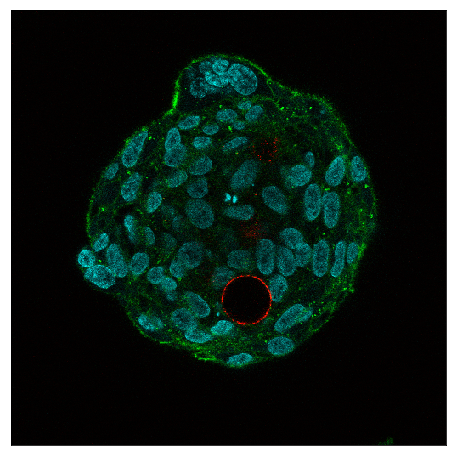

In [4]:
z_slice = bioformats.load_image(filename, series=0, z=71)

print np.shape(z_slice)

plt.figure(figsize=(8, 8))
plt.imshow(z_slice)
plt.xticks([])
plt.yticks([])
plt.show()

#### Split RGB channels (z=70)

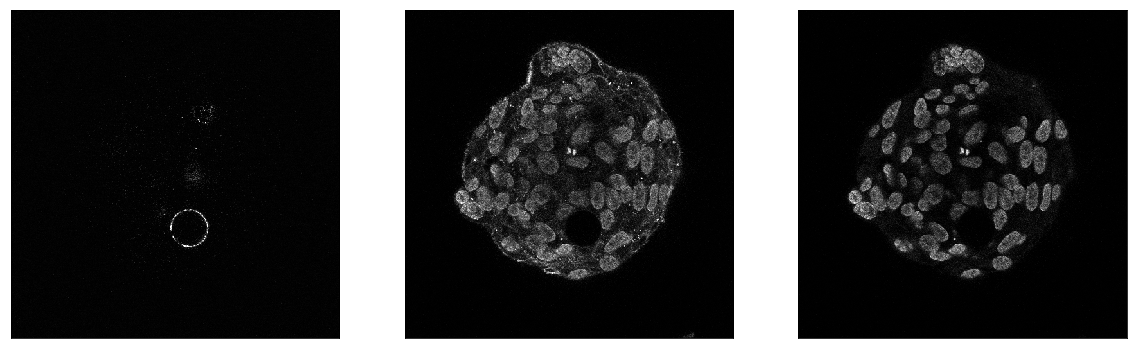

In [5]:
fig = plt.figure(figsize=(20, 20))

channel_keys = ['R', 'G', 'B']
split_channels = dict()

rows = 1
columns = 3
for i in range(1, columns*rows + 1):
    img = z_slice[:,:,i-1]
    maxintensity = np.max(img)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img/maxintensity, cmap=plt.get_cmap('gray'))
    split_channels[channel_keys[i-1]] = img/maxintensity
    plt.xticks([])
    plt.yticks([])
plt.show()

#### Background subtraction

(512, 512, 3)


([], <a list of 0 Text yticklabel objects>)

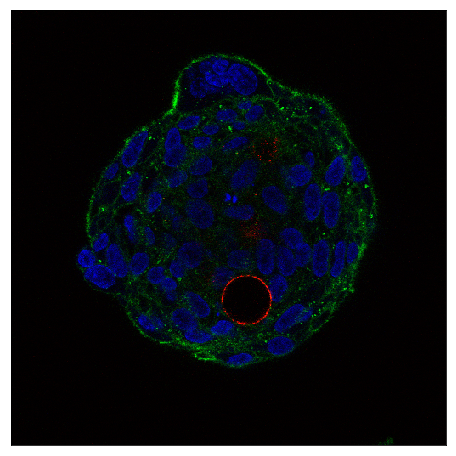

In [6]:
subtracted_img = split_channels['G'] - split_channels['B']
maxintensity = np.max(subtracted_img)
subtracted_img = subtracted_img/maxintensity
subtracted_img[subtracted_img < 0] = 0;

composite_img = np.zeros((nrows, ncols, 3))

composite_img[:, :, 0] = split_channels['R']
composite_img[:, :, 1] = subtracted_img
composite_img[:, :, 2] = split_channels['B']

print np.shape(composite_img)

plt.figure(figsize=(8,8))
plt.imshow(composite_img)
plt.xticks([])
plt.yticks([])

#### Construct volumetric image for blue channel

In [7]:
img_store = list()
for slc in range(nstacks):
    z_slice = bioformats.load_image(filename, series=0, z=slc)
    img_store.append(z_slice[:,:,2])

In [8]:
@jit
def construct_3D_volume(nrows, ncols, nstacks, filename):
    
    vol_disp = np.zeros((nrows, ncols, nstacks))
    
    for slc in range(nstacks):
        
        z_slice = img_store[slc]
        segmentation = skimage.segmentation.morphological_chan_vese(z_slice, 10)
        
        tmp = segmentation == True
        if np.sum(segmentation == True) > 100000:
            tmp = ~(segmentation == True)
            
        dt_img = ndimage.distance_transform_edt(tmp)
        vol_disp[:,:,slc] = np.fliplr(dt_img/np.max(dt_img))
        
    return vol_disp

In [9]:
vol_disp = construct_3D_volume(nrows, ncols, nstacks, filename)
print np.mean(vol_disp)
print np.shape(vol_disp)

0.030463180597508202
(512, 512, 194)


In [10]:
ipv.figure()
ipv.quickvolshow(vol_disp, level=[0.5], opacity=[1.0], level_width=0.1, width=800, height=600)

/home/labmember/anaconda2/lib/python2.7/site-packages/ipyvolume/serialize.py:66: RuntimeWarning: invalid value encountered in divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)


VBox(children=(VBox(children=(HBox(children=(Label(value=u'levels:'), FloatSlider(value=0.5, max=1.0, step=0.001), FloatSlider(value=0.0, max=1.0, step=0.001), FloatSlider(value=0.0, max=1.0, step=0.001))), HBox(children=(Label(value=u'opacities:'), FloatSlider(value=0.2, max=0.2, step=0.001), FloatSlider(value=0.0, max=0.2, step=0.001), FloatSlider(value=0.0, max=0.2, step=0.001))))), Figure(ambient_coefficient=1.0, camera_center=[0.0, 0.0, 0.0], data_max=1.0, diffuse_coefficient=0.0, height=600, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], specular_coefficient=0.0, style={'box': {'visible': True}, 'axes': {'color': 'black', 'visible': True, 'ticklabel': {'color': 'black'}, 'label': {'color': 'black'}}, 'background-color': 'white'}, tf=TransferFunctionWidgetJs3(level1=0.5, level2=0.0, level3=0.0, opacity1=1.0, opacity2=0.0, opacity3=0.0, width2=0.0, width3=0.0), volume_data=array([[[0.05263158, 0.05270463, 0.05076731, ..., 0.09264821,
         0.        , 0.        ],
        [0.03721615, 0.0372678 , 0.03589791, ..., 0.06551218,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.03721615, 0.0372678 , 0.03589791, ..., 0.06551218,
         0.        , 0.        ],
        [0.05263158, 0.05270463, 0.05076731, ..., 0.09264821,
         0.        , 0.        ]],

       [[0.03721615, 0.0372678 , 0.03589791, ..., 0.06551218,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.03721615, 0.0372678 , 0.03589791, ..., 0.06551218,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.03721615, 0.0372678 , 0.03589791, ..., 0.06551218,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.03721615, 0.0372678 , 0.03589791, ..., 0.06551218,
         0.        , 0.       

In [11]:
np.shape(vol_disp)

(512, 512, 194)

In [29]:
from skimage.feature import peak_local_max
pts = peak_local_max(vol_disp, min_distance=5)
print(len(pts))


1483


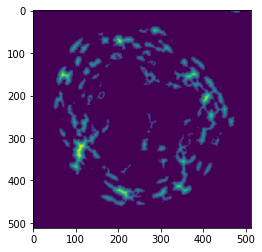

In [14]:
plt.imshow(vol_disp[:,:,150])

In [32]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
%matplotlib inline
from __future__ import division
init_notebook_mode(connected=True)
import plotly.plotly as py
import plotly
plotly.tools.set_credentials_file(username='zjneronha', api_key='PMrKGUGAet6kUZ5Rcf5E')
import pandas as pd


In [30]:
#define frame of interest

plt_data = []
trace = go.Scatter3d(
            name = "TestSeg",
            x = pts[:,0],
            y = pts[:,1],
            z = pts[:,2],
            mode = 'markers',
            marker = dict(
                color = 1,
                size = 8,
                symbol = 'circle',
                line = dict(
                    color = 'rgb(180, 180, 180)',
                    width = 1.0
                ),
                opacity = 0.4
            )
        )

plt_data.append(trace)

layout = go.Layout(margin = dict(l = 0, r = 0, b = 0, t = 0))

fig = go.Figure(data=plt_data, layout=layout)

iplot(fig)  

In [34]:
voidPT = pd.DataFrame(pts)
voidPT.to_csv("Spheroid_Pts_5.csv",index=False,header = False)